<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Proyecto Final

###  Extraer Tuits
Extraemos los tuits relacionados con la tematica de `Lana Rhoades`

In [2]:
import json
import pandas as pd
pd.set_option('display.max_colwidth', None)
import tweepy

with open('credentials.json') as f:
    keys = json.load(f)

# Autenticar a través de la API 
auth = tweepy.OAuthHandler(keys['api_key'], keys['api_secret_key'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [25]:
tweets = tweepy.Cursor(api.search,
                       q=['Lana Rhoades -RT'],
                       since='2021-05-31',
                       until='2021-06-02', 
                       lang='es',
                       #geocode='4.7110,-74.0721,100km',
                       tweet_mode='extended',
                       include_rts=False,
                       include_entities=True
                       ).items(3000)

In [26]:
# Objeto generador
t = [tweet for tweet in tweets]
t_processed = []

for tweet in t: 
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
    temp.append(tweet.user.location)
    temp.append(tweet.id)
    temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
    temp.append(tweet.favorite_count)
    if "media" in tweet.entities:
        temp.append(tweet.entities["media"][0]["media_url"])
    t_processed.append(temp)
    
data = pd.DataFrame(t_processed)
data.columns = ['tweets', 'date', 'user_location', 'id', 'link', 'likes','img_url']
data.head()

,tweets,date,user_location,id,link,likes,img_url
0,@EscritosLana en q momento dijo esto lana rhoades,2021-06-01 23:59:53,,1399878398839828480,https://twitter.com/i/web/status/1399878398839828480,0,None
1,"Lana Rhoades será madre, el último sello del apocalipsis ha sido roto, es hora de arrepentirnos de nuestros pecados.",2021-06-01 23:59:00,"Monterrey, Nuevo León",1399878176793403395,https://twitter.com/i/web/status/1399878176793403395,3,None
2,igual no es como que Lana Rhoades sepa que yo existo xd,2021-06-01 23:57:24,🆘,1399877772617687042,https://twitter.com/i/web/status/1399877772617687042,2,None
3,Lana Rhoades se hizo pancita y yo ya estoy llorando. ¿Se imaginan lo preciosa que se va a ver en su embarazo? Exijo muchas fotos para llorarle más.,2021-06-01 23:57:11,"𝐏𝒂𝒈𝒆 𝟏𝟏 • \'sa-nǝ-tē/ . . . En un intento loco, me enamoré de ti.",1399877719979069445,https://twitter.com/i/web/status/1399877719979069445,30,None
4,¿Quién fue el maldito que preñó a Lana Rhoades?,2021-06-01 23:57:09,"Bogotá, D.C., Colombia",1399877713272393732,https://twitter.com/i/web/status/1399877713272393732,0,None


In [27]:
import re 

data = data[['tweets', 'date','img_url','likes']]

pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweets']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
    
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag, "")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention, "")
        
    return text, links, hashtags, mentions
  
  
data[['texto_limpio', 'links', 'hashtags', 'mentions']] = data.apply(text_clean, axis=1, result_type='expand')

In [28]:
import regex
import emoji

def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)

    return emoji_list
  
  

data['emojis'] = data['texto_limpio'].apply(lambda text: get_emojis(text))
data.head()

,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis
0,@EscritosLana en q momento dijo esto lana rhoades,2021-06-01 23:59:53,None,0,en q momento dijo esto lana rhoades,[],[],[@EscritosLana],[]
1,"Lana Rhoades será madre, el último sello del apocalipsis ha sido roto, es hora de arrepentirnos de nuestros pecados.",2021-06-01 23:59:00,None,3,"Lana Rhoades será madre, el último sello del apocalipsis ha sido roto, es hora de arrepentirnos de nuestros pecados.",[],[],[],[]
2,igual no es como que Lana Rhoades sepa que yo existo xd,2021-06-01 23:57:24,None,2,igual no es como que Lana Rhoades sepa que yo existo xd,[],[],[],[]
3,Lana Rhoades se hizo pancita y yo ya estoy llorando. ¿Se imaginan lo preciosa que se va a ver en su embarazo? Exijo muchas fotos para llorarle más.,2021-06-01 23:57:11,None,30,Lana Rhoades se hizo pancita y yo ya estoy llorando. ¿Se imaginan lo preciosa que se va a ver en su embarazo? Exijo muchas fotos para llorarle más.,[],[],[],[]
4,¿Quién fue el maldito que preñó a Lana Rhoades?,2021-06-01 23:57:09,None,0,¿Quién fue el maldito que preñó a Lana Rhoades?,[],[],[],[]


###  Realizamos una visualización sobre esos tuits

In [29]:
data['hora'] = data['date'].dt.floor('15T').dt.time
temp = pd.DataFrame(data.hora.value_counts()).reset_index()
temp.columns = ['hora', 'cnt']
temp = temp.sort_values('hora')

In [30]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)


trace = go.Scatter(x=temp.hora.values,
                   y=temp.cnt.values,
                   text=[f"Fecha: {f}<br>Tuits: {c}" for f,c in zip(temp.hora.values,temp.cnt.values)],
                   hoverinfo='text',
                   mode='lines+markers',
                   name='Horas',
                   line={'color': 'blue'})

layout = go.Layout(title="Número de tuits por cada 15 minutos (1-Junio)")

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [31]:
from collections import Counter

temp_emojis = pd.DataFrame(list(zip(Counter(sum(data.emojis.values,[])).keys(),Counter(sum(data.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cnt']
temp_emojis.sort_values('cnt', ascending=False, inplace=True)

trace = go.Bar(x=temp_emojis.emoji.values[:15],
               y=temp_emojis.cnt.values[:15])

layout = go.Layout(title='Emojis más usados')

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [32]:
data.sort_values(by="likes", ascending=False).head(10)

,tweets,date,img_url,likes,texto_limpio,links,hashtags,mentions,emojis,hora
148,El bebé de lana rhoades cuando nazca: https://t.co/5Be8Lm9Vop,2021-06-01 22:54:09,http://pbs.twimg.com/media/E21O8NXWQAIYSG9.jpg,2931,El bebé de lana rhoades cuando nazca:,[https://t.co/5Be8Lm9Vop],[],[],[],22:45:00
96,"¡TERRIBLE NOTICIA! 🥺💔\n\nLana Rhoades está embarazada, llora el mundo entero. https://t.co/CN1wzj7K2f",2021-06-01 23:11:45,http://pbs.twimg.com/media/E21S99EXIAEXNDA.jpg,1832,"¡TERRIBLE NOTICIA! 🥺💔\n\nLana Rhoades está embarazada, llora el mundo entero.",[https://t.co/CN1wzj7K2f],[],[],"[🥺, 💔]",23:00:00
258,Volví\n ♥ si me extrañaron\n#LunesIntratable\n#LanaRhoades 🤭 https://t.co/Cip8FDBVaB,2021-06-01 00:31:26,http://pbs.twimg.com/media/E2wbk2fXIAQkisr.jpg,1553,Volví\n ♥ si me extrañaron\n\n 🤭,[https://t.co/Cip8FDBVaB],"[#LunesIntratable, #LanaRhoades]",[],"[♥, 🤭]",00:30:00
138,Se embarazó Lana Rhoades: https://t.co/d4ycYkb5S3,2021-06-01 22:56:58,http://pbs.twimg.com/media/E21PlXZXMAEnLnO.jpg,1170,Se embarazó Lana Rhoades:,[https://t.co/d4ycYkb5S3],[],[],[],22:45:00
201,"Lana Rhoades acaba de anunciar que está embarazada. Salganse de twitter, quiero estar solo https://t.co/Db94pRuNmO",2021-06-01 22:36:30,http://pbs.twimg.com/media/E21K5SwXwAQHKdD.jpg,964,"Lana Rhoades acaba de anunciar que está embarazada. Salganse de twitter, quiero estar solo",[https://t.co/Db94pRuNmO],[],[],[],22:30:00
69,Lana Rhoades embarazada/ su hijo https://t.co/Hw3hdN7QzN,2021-06-01 23:27:26,http://pbs.twimg.com/media/E21WjgtWUAAAbaa.jpg,483,Lana Rhoades embarazada/ su hijo,[https://t.co/Hw3hdN7QzN],[],[],[],23:15:00
194,"A través de su cuenta de instagram, Lana Rhoades confirma que será mamá. https://t.co/zzdf5N25QF",2021-06-01 22:39:45,http://pbs.twimg.com/media/E21LpPBUUAAIGHu.jpg,342,"A través de su cuenta de instagram, Lana Rhoades confirma que será mamá.",[https://t.co/zzdf5N25QF],[],[],[],22:30:00
49,Lana Rhoades esta preñá y tu encabronao q tu baby subió una foto en traje baño,2021-06-01 23:34:20,None,268,Lana Rhoades esta preñá y tu encabronao q tu baby subió una foto en traje baño,[],[],[],[],23:30:00
100,Lana rhoades quedó embarazada https://t.co/CmKJ4AR4Ld,2021-06-01 23:10:24,http://pbs.twimg.com/media/E21SqK0XoAMylkp.jpg,226,Lana rhoades quedó embarazada,[https://t.co/CmKJ4AR4Ld],[],[],[],23:00:00
43,"Lana Rhoades está embarazada, y no de mí… https://t.co/QSrbykZjIH",2021-06-01 23:37:11,http://pbs.twimg.com/media/E21YyEKWEAALwM6.jpg,199,"Lana Rhoades está embarazada, y no de mí…",[https://t.co/QSrbykZjIH],[],[],[],23:30:00


<img src="http://pbs.twimg.com/media/E21O8NXWQAIYSG9.jpg" width="350" height="500">
<img src="http://pbs.twimg.com/media/E21WjgtWUAAAbaa.jpg" width="350" height="500">

In [33]:
import re
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display
stopwords = stopwords.words("spanish")
 
stopwords.extend(["lana", "rhoades"])

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = [palabra for palabra in texto.split() if palabra not in stopwords]
    texto = " ".join(texto)
    return texto

data['pp'] = data.texto_limpio.apply(lambda texto: pre_procesado(texto))

palabras = data.pp.str.cat(sep=" ")

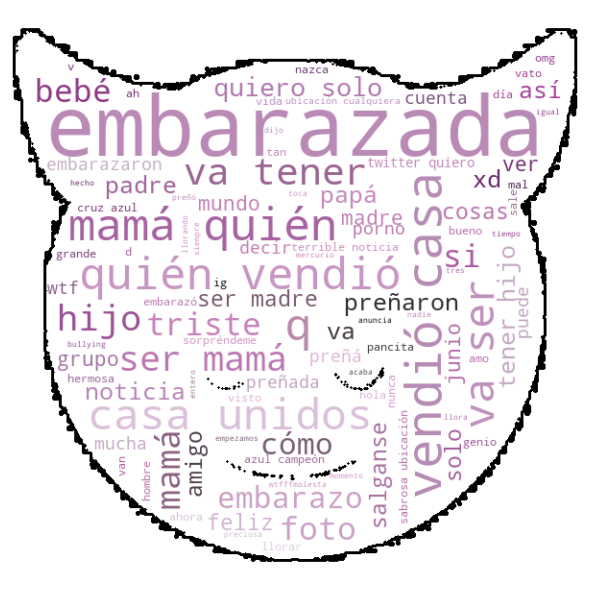

In [34]:
# CARGAR IMAGEN 
img = PIL.Image.open("emoji.jpg")
mask = np.array(img)

wordcloud = WordCloud(width=800, height=400,
                      max_font_size=150, max_words=100,
                      background_color="white", colormap="spring",
                      stopwords=stopwords, collocations=True,
                      mask=mask, contour_width=2, contour_color='black').generate(palabras) # https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

image_colors=ImageColorGenerator(mask)

# wordcloud.to_file("test.png")

plt.figure(figsize=(10,8))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()